# HISEAS LIG SST Visualization
#### Elli S., Anna C., Jannik M.
#### Updated by AC on Feb 20, 2025

### Takes in data from the harmonized Hoffman et al. Excel spreadsheet and plots SSTs of each proxy type

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import geopandas as gpd
import geodatasets
import warnings

# Filter out warnings from openpyxl regarding unknown extensions.
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")
# Filter out pyproj warnings regarding converting masked elements to nan.
warnings.filterwarnings("ignore", message="Warning: converting a masked element to nan.")

In [6]:
# Open the Excel file and retrieve sheet names
excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# List of sheet names to remove
sheets_to_remove = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

# Remove each sheet in sheets_to_remove if it exists in core_ID_list
for sheet in sheets_to_remove:
    if sheet in sheet_names:
        sheet_names.remove(sheet)

print("List of tabs with data in the Excel file:")
print(sheet_names)

List of tabs with data in the Excel file:
['M23323-1_UK37', 'M23323-1_Foram', 'V28-14', 'EW9302-JPC8', 'odp 980', 'NA87-25', 'V27-20', 'M23414-9', 'NEAP18k', 'V23-82', 'K708-1', 'MD04-2845', 'V29-179', 'SU92-03', 'D-117', 'CH69k09', 'V30-97', 'MD95-2040_UK37', 'MD95-2040_Foram', 'SU90-03', 'MD01-2444_UK37', 'MD01-2444_MgCa', 'MD95-2036', 'KNR140-37JPC', 'MD02-2575', 'GIK15637-1', 'M12392-1', 'TR126-29', 'TR126-23', 'M35027-1', 'V22-196', 'V28-127', 'MD03-2707', 'V25-59', 'Y7211-1', 'ODP1020', 'ODP1018', 'MD01-2421', 'ODP893', 'ODP1014A', 'ODP1012', 'LAPAZ21', 'ODP1145', 'ODP1146', 'MD97-2151', 'GIK17961-2', 'V28-238', 'W8402A', 'TR163-22', 'ODP846', 'V19-29', 'Y71-6-12', 'MD06-3018', 'MD97-2121', 'RC15-61', 'ODP1123', 'MD97-2106', 'DSDP594', 'MD97-2120', 'Y9', 'MD97-2108', 'MD97-2109', 'V34-88', 'RC12-339', 'GeoB10038-4_MgCa', 'GeoB10038-4_UK37', 'MD01-2378', 'V28-345', 'MD94-101', 'MD84-527', 'MD94-102', 'MD73-25', 'MD88-770_Diatom', 'MD88-770_Foram', 'MD02-2488', 'V22-182_Foram', 'V2

In [7]:
# Define proxy marker mapping
proxy_marker_map = {
    "Foram": "o",      # Circle
    "UK37": "^",       # Triangle
    "MgCa": "s",       # Square
    "Radiolaria": "D", # Diamond
    "Cocc": "P",       # Plus
    "Diatom": "X"      # Filled-X
}

Enter a specific year (e.g., 115000):  120000


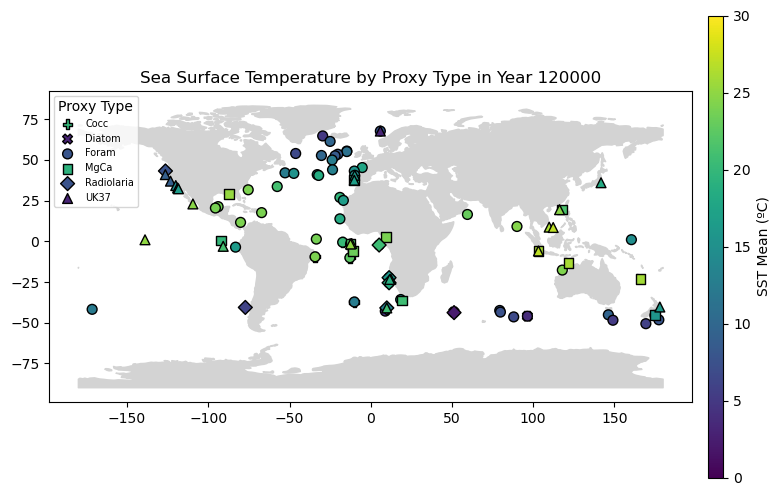

The data frame of records in year 120000 is:
     Longitude  Latitude       Proxy        SST    SST+2sd    SST-2sd
0         5.92     67.77        UK37   3.110171  11.357215   7.869590
1         5.92     67.77       Foram   7.902344  13.316525  10.577386
2       -29.57     64.78       Foram   4.956626  12.133205   9.371383
3       -25.00     61.42       Foram   9.822224  16.242030  12.797526
4       -14.70     55.48       Foram  10.000830  17.159662  13.638496
..         ...       ...         ...        ...        ...        ...
99      -10.10    -37.27       Foram  12.522001  19.491818  16.176455
100     -10.10    -37.27        Cocc  13.014637  19.545415  16.289241
101       9.90    -40.93        UK37  20.761697  23.757238  22.263968
102       9.90    -40.93  Radiolaria  12.619517  18.113695  15.376316
103       8.97    -42.90       Foram   4.585162  10.900199   7.923457

[104 rows x 6 columns]


In [12]:
def extract_record_for_sheet(sheet, year_input):
    """
    For a given sheet name and year:
      - Reads columns B, C, D (Longitude, Latitude, Proxy) and extracts row 2 (first data row).
      - Reads columns Q and S (Age and SST Mean), finds the row where Age matches the given year,
        and extracts the SST Mean.
      - Returns a dictionary with keys: "Longitude", "Latitude", "Proxy", and "SST".
      - If no matching year is found, returns None.
    """
    try:
        # Read base info (columns B, C, D) from row 2 only.
        df_base = pd.read_excel(excel_file, sheet_name=sheet, usecols="A,B,C,D")
        df_base.columns = ['ID', 'Longitude', 'Latitude', 'Proxy']
        # Row 2 is the first data row (index 0)
        ID = df_base.iloc[0]['ID']
        lon = df_base.iloc[0]['Longitude']
        lat = df_base.iloc[0]['Latitude']
        proxy = df_base.iloc[0]['Proxy']
    except Exception as e:
        print(f"Error reading base info from sheet {sheet}: {e}")
        return None

    try:
        # Read age and SST info (columns Q and S) for all rows.
        df_sst = pd.read_excel(excel_file, sheet_name=sheet, usecols="Q,S,R,T")
        df_sst.columns = ['Age', 'SST', 'SST-2sd', 'SST+2sd']
        # Find the row where Age matches the entered year.
        match = df_sst[df_sst['Age'] == year_input]
        if match.empty:
            print(f"Year {year_input} not found in sheet {sheet}.")
            return None
        # Extract the SST value from the first matching row.
        sst_val = match.iloc[0]['SST']
        sst_upper_val = match.iloc[0]['SST+2sd']
        sst_lower_val = match.iloc[0]['SST-2sd']
    except Exception as e:
        print(f"Error reading SST info from sheet {sheet}: {e}")
        return None

    return {"ID": ID, "Longitude": lon, "Latitude": lat, "Proxy": proxy, 
            "SST": sst_val, "SST+2sd": sst_upper_val, "SST-2sd": sst_lower_val}

def build_gdf(year_input):
    """
    Loop through all sheets, extract records for the given year, and return a DataFrame.
    """
    records = []
    for sheet in sheet_names:
        rec = extract_record_for_sheet(sheet, year_input)
        if rec is not None:
            records.append(rec)
    if records:
        return pd.DataFrame(records)
    else:
        return pd.DataFrame()

def plot_proxy_data(gdf):
    """
    Plots the data grouped by proxy type onto a world map.
    """
    # Set up colormap and fixed normalization from 5 to 30 ºC.
    cmap = plt.cm.viridis
    norm = colors.Normalize(vmin=0, vmax=30)
    
    # Load world map from geodatasets via GeoPandas.
    world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
    
    # Create the plot.
    fig, ax = plt.subplots(figsize=(10, 6))
    world.plot(ax=ax, color='lightgrey', edgecolor='lightgrey')
    
    # Group the data by proxy type and plot each group.
    for proxy, group in gdf.groupby("Proxy"):
        ax.scatter(
            group['Longitude'], group['Latitude'],
            marker=proxy_marker_map.get(proxy, "o"),
            c=group['SST'],
            cmap=cmap, norm=norm,
            edgecolor="black", s=50,
            label=proxy
        )
    
    # Add a colorbar for SST values.
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label("SST Mean (ºC)")
    
    # Add legend for proxy types.
    ax.legend(title="Proxy Type", loc='upper left', prop={'size': 7})
    plt.title(f"Sea Surface Temperature by Proxy Type in Year {year_input}")
    plt.show()

if __name__ == "__main__":
    try:
        year_input = int(input("Enter a specific year (e.g., 115000): "))
    except ValueError:
        print("Invalid year input.")
        exit()

    # Build the DataFrame of records.
    gdf = build_gdf(year_input)
    if gdf.empty:
        print("No records found for the given year.")
    else:
        # Plot the data grouped by proxy type.
        plot_proxy_data(gdf)
    
    # Print the DataFrame of records.
    print(f"The data frame of records in year {year_input} is:")
    print(gdf)

## Below is the old code used for Elli's Google Sheet
### Use the code above, ignore the code below